In [11]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as ac
from scipy import special
import string
import re
import random
from tqdm import tqdm

from collections import Counter
from sklearn.metrics import accuracy_score

Фиксируем сид рандомайзера:

In [12]:
random.seed = 42
np.random.seed(42)

In [14]:
!head corpora/WarAndPeaceEng.txt

﻿The Project Gutenberg EBook of War and Peace, by Leo Tolstoy

This eBook is for the use of anyone anywhere at no cost and with almost
no restrictions whatsoever.  You may copy it, give it away or re-use it
under the terms of the Project Gutenberg License included with this
eBook or online at www.gutenberg.org


Title: War and Peace



In [15]:
text_ru_path = 'corpora/WarAndPeace.txt'
text_en_path = 'corpora/WarAndPeaceEng.txt'

In [39]:
def get_clean_text(path, regexp):
    with open(path, 'r') as file:
        text = file.read().lower()
    only_words = re.subn(pattern=regexp, repl=' ', string=text)[0]
    text = ' '.join(only_words.split())
    return text

In [43]:
text_ru = get_clean_text(text_ru_path, '[^а-я]')
text_en = get_clean_text(text_en_path, '[^a-z]')

In [45]:
ALPHABET_RU = 'абвгдежзийклмнопрстуфхцчшщъыьэюя '
ALPHABET_EN = 'abcdefghijklmnopqrstuvwxyz '

In [46]:
RU_TO_ID = {char : i for i, char in enumerate(ALPHABET_RU)}
EN_TO_ID = {char : i for i, char in enumerate(ALPHABET_EN)}

Для унификации работы алгоритма (и языков) перейдем к численному представлению символов алфавита

In [156]:
def apply_substitution(substitution, data):
    return np.array([substitution[char] for char in data])

In [157]:
data_ru = apply_substitution(RU_TO_ID, text_ru)
data_en = apply_substitution(EN_TO_ID, text_en)

assert len(data_ru) == len(text_ru)
assert len(data_en) == len(text_en)

In [12]:
initial_values_for_ctr_eng = apply_substitution(ENG_MAPPER, ENG_ALPH)
all_data_eng = apply_substitution(ENG_MAPPER, text_eng_clean)

initial_values_for_ctr_ru = apply_substitution(RU_MAPPER, RU_ALPH)
all_data_ru = apply_substitution(RU_MAPPER, text_ru_clean)

# Пункт 1

Реализуйте базовый частотный метод по Шерлоку Холмсу:
 - подсчитайте частоты букв по корпусам (пунктуацию и капитализацию можно просто опустить, а вот пробелы лучше оставить);
 - возьмите какие-нибудь тестовые тексты (нужно взять по меньшей мере 2-3 предложения, иначе вряд ли сработает), зашифруйте их посредством случайной перестановки символов;
 - расшифруйте их таким частотным методом.


In [103]:
distr_en = Counter(data_en)

In [104]:
key = np.random.permutation(len(ALPHABET_EN))

In [105]:
chunk_size = 300
open_text = data_en[:chunk_size]

In [106]:
cipher_text = apply_substitution(key, open_text)

In [107]:
distr_cipher_text = Counter(np.concatenate((np.arange(len(ALPHABET_EN)), cipher_text)))

In [108]:
inv_key = np.full(len(ALPHABET_EN), fill_value=-1)
for i, j in zip(distr_cipher_text.most_common(), distr_en.most_common()):
    inv_key[i[0]] = j[0]

In [109]:
decrypted_text = apply_substitution(inv_key, cipher_text)

In [110]:
accuracy_score(decrypted_text, open_text)

0.4

Посмотрим на зависимость длины открытого текста от качества дешифровки:

In [148]:
def gram_accuracy(data, alphabet, size, key=key):
    distr = Counter(data)
    chunk_size = size
    open_text = data[:chunk_size]
    cipher_text = apply_substitution(key, open_text)
    distr_cipher_text = Counter(np.concatenate((np.arange(len(alphabet)), cipher_text)))

    inv_key = np.full(len(alphabet), fill_value=-1)
    for i, j in zip(distr_cipher_text.most_common(), distr.most_common()):
        inv_key[i[0]] = j[0]
    
    decrypted_text = apply_substitution(inv_key, cipher_text)
    return accuracy_score(decrypted_text, open_text)

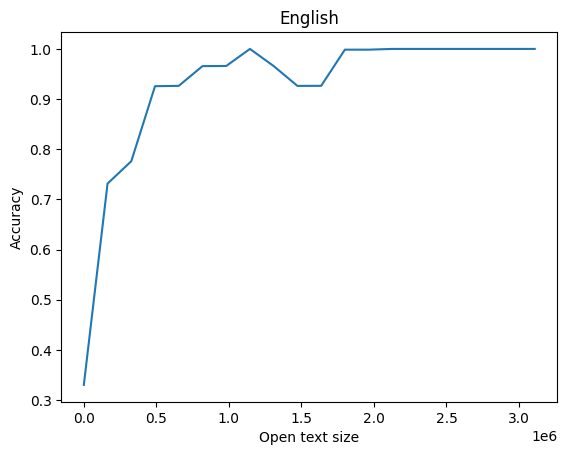

In [150]:
key_en = np.random.permutation(len(ALPHABET_EN))

x_steps_en = np.linspace(100, len(data_en), num=20, dtype=int)
y_steps_en = [gram_accuracy(data_en, ALPHABET_EN, x, key) for x in x_steps_en]
plt.plot(x_steps_en, y_steps_en)
plt.title('English')
plt.xlabel('Open text size')
plt.ylabel('Accuracy')
plt.show()

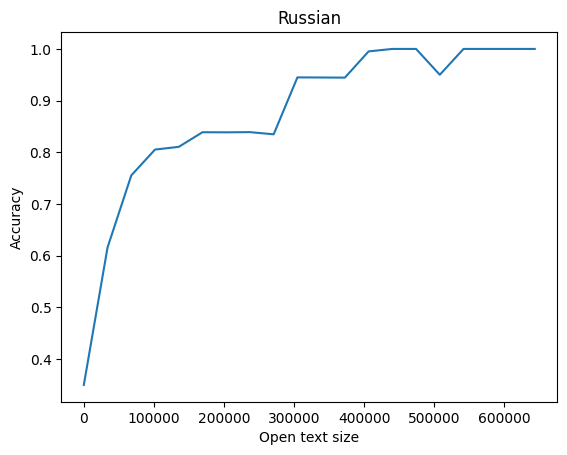

In [151]:
key_ru = np.random.permutation(len(ALPHABET_RU))


x_steps_ru = np.linspace(100, len(data_ru), num=20, dtype=int)
y_steps_ru = [gram_accuracy(data_ru, ALPHABET_RU, x, key_ru) for x in x_steps_ru]
plt.plot(x_steps_ru, y_steps_ru)
plt.title('Russian')
plt.xlabel('Open text size')
plt.ylabel('Accuracy')
plt.show()

Заметим, что в процентном соотношении числа символов в тексте от размера корпуса, английский язык немного быстрее растет в качестве (к 30% датасета точность=0.95, в русском же корпусе 30% текста соответствует примерно 0.85 точности)

# Пункт 2

## Биграммы

Аналогично считаем частоты биграмм для всего текста

In [153]:
def bigrams_accuracy(data, alphabet, size, key=key):
    bigrams = zip(data, data[1:])
    distr_bigrams = Counter(bigrams)
    
#     key = np.random.permutation(len(alphabet))
    chunk_size = size
    open_text = data[:chunk_size]
    cipher_text = apply_substitution(key, open_text)
    
#     distr_cipher_text = Counter(np.concatenate((np.arange(len(alphabet)), cipher_text)))
    
    cipher_text_bigrams = zip(cipher_text,cipher_text[1:])
    distr_bigrams_cipher = Counter(cipher_text_bigrams)
    
    inv_key = np.full(len(alphabet), fill_value=-1)
    
    z = list(zip(distr_bigrams.most_common(), distr_bigrams_cipher.most_common()))
    for o, c in z:
        if inv_key_bigrams[c[0][0]] == -1:
            inv_key_bigrams[c[0][0]] = o[0][0]

        if inv_key_bigrams[c[0][1]] == -1:
            inv_key_bigrams[c[0][1]] = o[0][1]
            
    
    decrypted_text = apply_substitution(inv_key_bigrams, cipher_text)
    return accuracy_score(decrypted_text, open_text)

In [140]:
# key = np.random.permutation(len(ALPHABET_EN))

In [144]:
# bigrams_accuracy(data_en, ALPHABET_EN, 30000, key)

0.09993333333333333

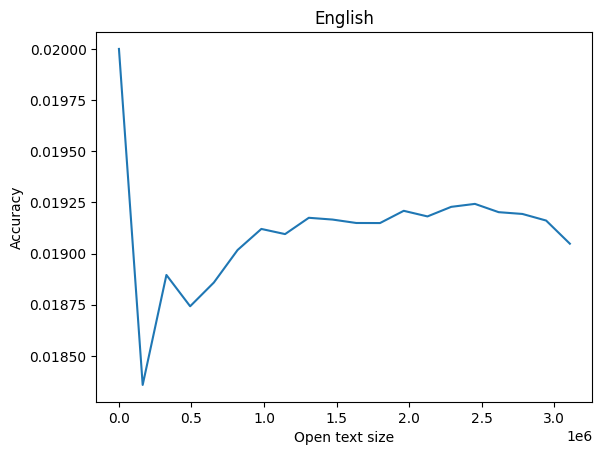

In [154]:
x_steps_en = np.linspace(100, len(data_en), num=20, dtype=int)
y_steps_en = [bigrams_accuracy(data_en, ALPHABET_EN, x, key_en) for x in x_steps_en]
plt.plot(x_steps_en, y_steps_en)
plt.title('English')
plt.xlabel('Open text size')
plt.ylabel('Accuracy')
plt.show()

Качество просело(